In [ ]:
import math
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import numba
from numba import njit
import time
from matplotlib.pyplot import figure
from numba.typed import List
from collections import defaultdict


# Data

In [ ]:
n = 1000 # số đơn
item_list = []
for i in range(n):
    m = 100 # số item trong 1 đơn
    item = np.random.randint(20, 40, (m, 5))
    item[:,2] = 0
    item[:,3] = 0
    item[:,4] = -1
    item_list.append(item)

# tọa độ các đơn hàng
X = np.random.randint(0, n, size=(n, 2))

k = 9 # số kho
bin = np.array([3500,3500, 0, 0, 1], np.int_) # kích thước thùng hàng
ratio_bin_used = np.zeros(k) # tỉ lệ bin đã dùng

# Binary search binpacking

In [ ]:
# hàm tạo lời giải bằng thuật toán shelf
@njit
def shelf(item, bin, s, k):
    pi_x = 0
    pi_y = 0
    max_length = item[s[0], 0]
    for i in s:
        # bỏ qua các item quá bin
        if item[i,1] > bin[1] or item[i,0] > bin[0]:
          continue
        if pi_y + item[i, 1] > bin[1]:
            pi_x += max_length
            pi_y = 0
            max_length = item[i, 0]
        if pi_x + item[i, 0] > bin[0]:
            break
        item[i, 2] = pi_x
        item[i, 3] = pi_y
        if k != -1:
            item[i, 4] = k
        pi_y += item[i, 1]
    return item

In [ ]:
@njit
def binary_bin_packing(item, bin, idx):
    bin_list = np.empty((1,5), np.int_)
    bin_list[0] = bin
    k = 0
    ratio = 1.0
    total = 0.0
    i = 0
    change = False
    bin_pack = np.empty((0,5), np.int_)
    while True:
        # xếp item dư vào bin
        item1 = item[item[:,4] == -1]
        s = np.argsort(- item1[:,0])
        solve_item = shelf(item1, bin_list[i],s , k)
        # item đã xếp vào bin
        item_pack = solve_item[solve_item[:,4] == k]
        # item dư
        item_left = solve_item[solve_item[:,4] == -1]
        # không có item dư
        if len(item_left) == 0:
            # lưu kết quả trước
            note_item = np.copy(solve_item)
            note_bin = np.copy(bin_list[i])
            # tạo bin mới
            ratio /= 2
            new_bin_list = np.empty((len(bin_list) + 1, 5), np.int_)
            new_bin_list[:i] = bin_list[:i]
            new_bin_list[i] = bin_list[i]
            new_bin_list[i+1:] = bin_list[i:]
            new_bin_list[i,4] *= 2
            new_bin_list[i+1,4] *= 2
            # chia theo chiều rộng
            if bin_list[i, 0] >= bin_list[i, 1]:
               new_bin_list[i,0] //= 2
               new_bin_list[i+1,0] //= 2
               new_bin_list[i+1,2] += new_bin_list[i+1,0]
            # chia theo chiều dài
            else:
               new_bin_list[i,1] //= 2
               new_bin_list[i+1,1] //= 2
               new_bin_list[i+1,3] += new_bin_list[i+1,1]
            bin_list = np.copy(new_bin_list)
            change = True
        # có item dư
        else:
            # lời giải hiện tại có item đã xếp
            if len(item_pack) > 0:
                # lưu các item đã pack
                item[item[:,4] == -1] = solve_item
                new_bin_pack = np.empty((len(bin_pack) + 1, 5), np.int_)
                new_bin_pack[:-1] = bin_pack
                new_bin_pack[-1] = bin_list[i]
                new_bin_pack[-1,-1] = idx
                bin_pack = np.copy(new_bin_pack)
                k += 1
                total += ratio
                change = False
                if i + 1 < len(bin_list):
                    i += 1
                    ratio = 1/bin_list[i,4]
                else:
                    bin_list = np.empty((1,5), np.int_)
                    bin_list[0] = bin
                    total += ratio
                    ratio = 1.0
                    i = 0
            # lời giải hiện tại không có item nào được xếp
            elif len(item_pack) == 0:
                if change or i + 1 > len(bin_list):
                    item[item[:,4] == -1] = note_item
                    new_bin_pack = np.empty((len(bin_pack) + 1, 5), np.int_)
                    new_bin_pack[:-1] = bin_pack
                    new_bin_pack[-1] = note_bin
                    new_bin_pack[-1,-1] = idx
                    ratio = 1/note_bin[4]
                    total += ratio
                    bin_pack = np.copy(new_bin_pack)
                    break
                else:
                    i += 1
                    ratio = 1/bin_list[i,4]
    return total, item, bin_pack

In [ ]:
# tỉ lệ chiếm dụng bin của từng đơn hàng
ratio_bin = np.empty(len(item_list))
# kích thước các bin cần dùng cho mỗi đơn hàng
bin_pack_list = np.empty((0,5), np.int_)
for i in range(len(item_list)):
    ratio_bin[i], item_list[i], bin_pack = binary_bin_packing(item_list[i], bin, i)
    bin_pack_list = np.concatenate((bin_pack_list, bin_pack))

0.0079345703125


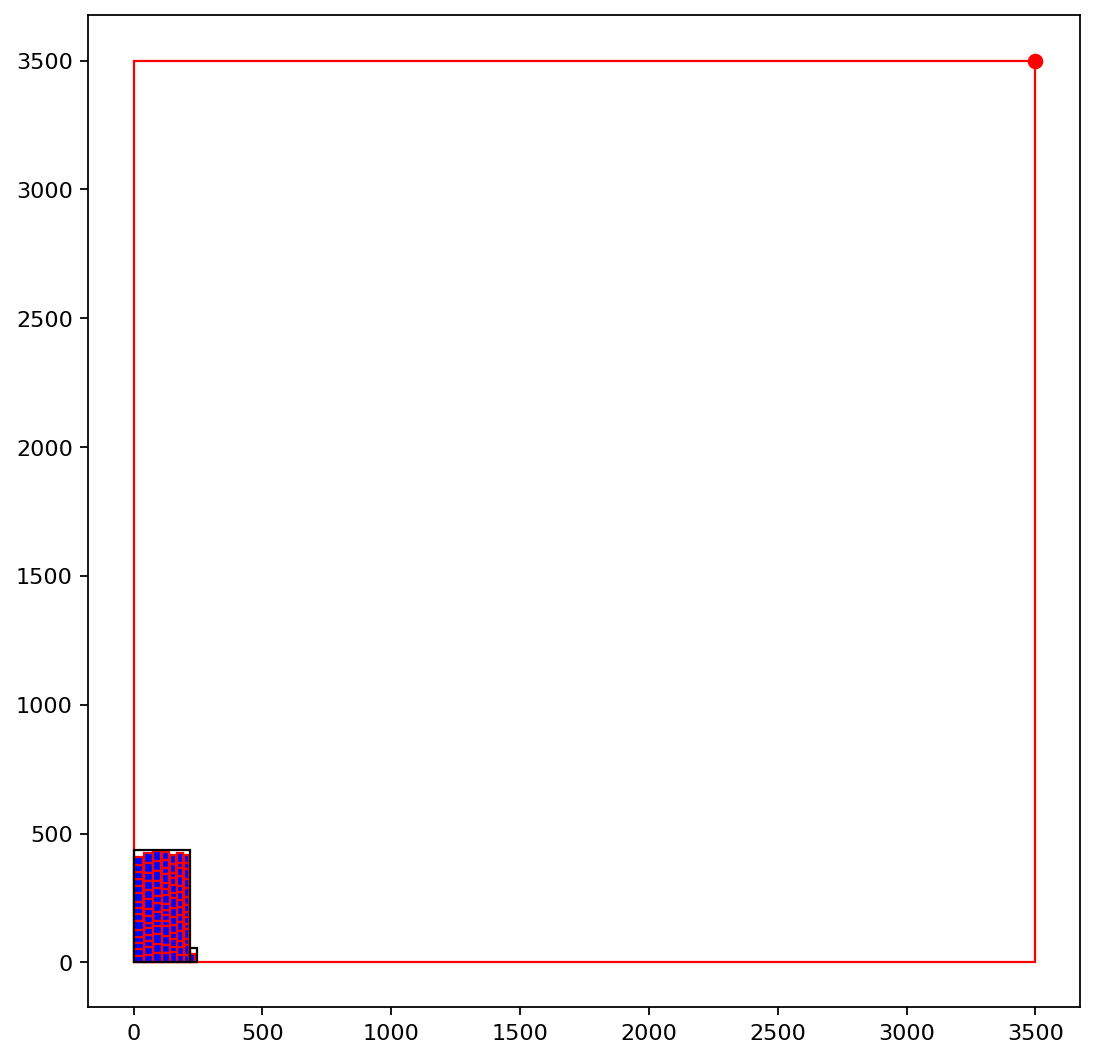

In [ ]:
from matplotlib.patches import Rectangle
def rec(x,y,l,w,color1, color2):
    rec= Rectangle((x,y),l,w,linewidth=1,edgecolor=color1,facecolor=color2)
    plt.gca().add_patch(rec)
from matplotlib.pyplot import figure

figure(figsize=(8, 16), dpi=160)
plt.gca().set_aspect('equal')

plt.plot(bin[0], bin[1], "ro")
rec(x=0,y=0,l=bin[0],w=bin[1],color1 = "r", color2='none')
i = 1
item = item_list[i]
bin_pack = bin_pack_list[bin_pack_list[:,4] == i]
item_pack = item[item[:,4] != -1]
print(ratio_bin[i])
for i in range(len(item_pack)):
    rec(x=item_pack[i,2] + bin_pack[item_pack[i, 4], 2], y=item_pack[i,3] + bin_pack[item_pack[i, 4], 3],l=item_pack[i,0],w=item_pack[i,1], color1 = "r", color2="blue")
for j in range(len(bin_pack)):
    rec(x=bin_pack[j,2],y=bin_pack[j,3],l=bin_pack[j,0],w=bin_pack[j,1],color1 = "black", color2='none')

# K-mean

In [ ]:
# hàm tính khoảng cách 2 điểm trong không gian euclide
@njit
def euclidean_distance(point1, point2):
    return (int)(np.sqrt(np.sum((point1 - point2) ** 2)))

In [ ]:
# hàm kiểm tra vượt quá dung tích bin không
@njit
def check_over_bin(idx_item, idx_centroids, ratio_bin_used):
    if ratio_bin[idx_item] + ratio_bin_used[idx_centroids] <= 1.0:
        return False
    return True

In [ ]:
# Hàm tìm kho gần nhất cho một điểm giao hàng
@njit
def find_nearest_centroids(idx_item, centroids_list, ratio_bin_used):
    min_distance = 10000000
    nearest_centroids = -1
    for idx_centroids, centroids in enumerate(centroids_list):
        distance = euclidean_distance(X[idx_item], centroids)
        if check_over_bin(idx_item, idx_centroids, ratio_bin_used):
            continue
        if distance < min_distance:
            min_distance = distance
            nearest_centroids = idx_centroids
    return nearest_centroids

In [ ]:
# Hàm gán điểm cho các cụm
@njit
def assign_clusters(X, centroids_list, ratio_bin_used):
    clusters = np.zeros(len(X), np.int_)
    s = np.argsort(X[:,0]*X[:,0] + X[:,1]*X[:,1])
    for idx_item in s:
        idx_centroids = find_nearest_centroids(idx_item, centroids_list, ratio_bin_used)
        clusters[idx_item] = idx_centroids
        if idx_centroids != -1:
            ratio_bin_used[idx_centroids] += ratio_bin[idx_item]
    return clusters

In [ ]:
# Hàm cập nhật trọng tâm cụm
@njit
def update_centroids(X, clusters):
    centroids_list = np.zeros((k,2), np.int_)
    for i in range(k):
        cluster_points = X[clusters == i]
        centroids_x = 0
        centroids_y = 0
        for j in range(len(cluster_points)):
            centroids_x += cluster_points[j,0]
            centroids_y += cluster_points[j,1]
        centroids_x //= len(cluster_points)
        centroids_y //= len(cluster_points)
        centroids_list[i,0], centroids_list[i, 1] = centroids_x, centroids_y
    return centroids_list

In [ ]:
# Thuật toán K-means
@njit
def k_means(X, max_iterations):
    centroids_list = X[np.random.choice(X.shape[0], k, replace=False)]
    for _ in range(max_iterations):
        # tạo mới tỉ lệ sử dụng bin
        ratio_bin_used = np.zeros(k, np.float_)

        # Gán điểm cho các cụm dựa trên các trọng tâm đã cho trước
        clusters = assign_clusters(X, centroids_list, ratio_bin_used)

        # Lặp lại cho đến khi không có sự thay đổi đáng kể trong các tâm cụm
        new_centroids_list = update_centroids(X, clusters)

        # kiểm tra xem có sự thay đổi của tâm cụm không
        if np.all(centroids_list == new_centroids_list):
            break
        centroids_list = new_centroids_list
    return clusters, centroids_list, ratio_bin_used

In [ ]:
clusters, centroids_list, ratio_bin_used = k_means(X, 1000)

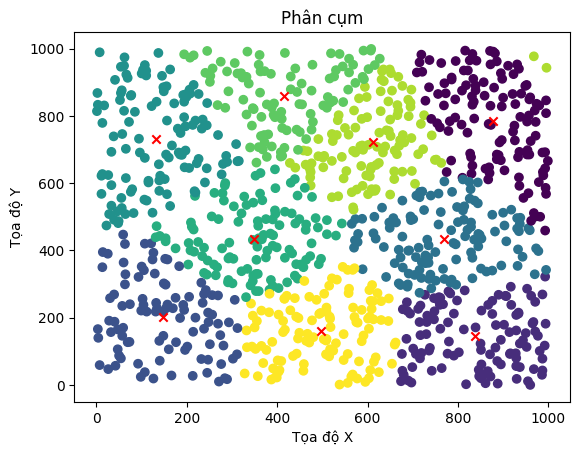

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis')
plt.scatter(centroids_list[:, 0], centroids_list[:, 1], marker='x', color='red')
plt.title('Phân cụm')
plt.xlabel('Tọa độ X')
plt.ylabel('Tọa độ Y')
plt.show()

In [ ]:
def guillotine(bin_pack, bin, s):
    bin_list = np.empty((1,4), np.int_)
    bin_list[0] = bin[:-1]
    min_length = min([x[0] for x in bin_pack])
    min_width = min([x[1] for x in bin_pack])
    for i in s:
      for j in range(len(bin_list)):
          if bin_pack[i, 0] <= bin_list[j][0] and bin_pack[i, 1] <= bin_list[j][1]:
              bin_left = np.array([bin_pack[i, 0], bin_list[j][1] - bin_pack[i, 1], bin_list[j,2], bin_list[j,3] + bin_pack[i,1]], np.int_)
              bin_right = np.array([bin_list[j][0] - bin_pack[i, 0], bin_list[j][1], bin_list[j,2] + bin_pack[i, 0], bin_list[j,3]], np.int_)
              bin_pack[i,2] = bin_list[j,2]
              bin_pack[i,3] = bin_list[j,3]
              if bin_right[0] >= min_length and bin_left[1] >= min_width:
                  new_bin_list = np.empty((len(bin_list) + 1, 4), np.int_)
                  new_bin_list[:j] = bin_list[:j]
                  new_bin_list[j] = bin_left
                  new_bin_list[j+1] = bin_right
                  new_bin_list[j+2:] = bin_list[j+1:]
                  bin_list = new_bin_list
              elif bin_right[0] >= min_length: bin_list[j] = bin_right
              elif bin_left[1] >= min_width: bin_list[j] = bin_left
              else:
                  new_bin_list = np.empty((len(bin_list) - 1, 4), np.int_)
                  new_bin_list[:j] = bin_list[:j]
                  new_bin_list[j:] = bin_list[j+1:]
                  bin_list = new_bin_list
              break
    return bin_pack

In [ ]:
def draw_bin(idx_cluster):
    bin_pack = np.empty((0, 5), np.int_)
    for i in range(len(item_list)):
        if clusters[i] == idx_cluster:
            new_bin_pack = bin_pack_list[bin_pack_list[:,4] == i]
            bin_pack = np.concatenate((bin_pack, new_bin_pack))
    s = np.argsort(- bin_pack[:,0] - bin_pack[:,1])
    bin_pack = guillotine(bin_pack, bin, s)
    return bin_pack

In [ ]:
def draw_item(idx_cluster):
    item_pack = np.empty((0,5), np.int_)
    for i in range(len(item_list)):
        if clusters[i] == idx_cluster:
            item = np.copy(item_list[i])
            bin_size = bin_pack[bin_pack[:,4] == i]
            for j in range(len(bin_size)):
                for idx in range(len(item)):
                    if item[idx, 4] == j:
                        item[idx,2] += bin_size[j,2]
                        item[idx,3] += bin_size[j,3]
            item_pack = np.concatenate((item_pack, item))
    return item_pack

In [ ]:
ratio_bin_used

array([0.99835205, 0.92565918, 0.82189941, 0.99987793, 0.97088623,
       0.95788574, 0.80529785, 0.92541504, 0.95001221])

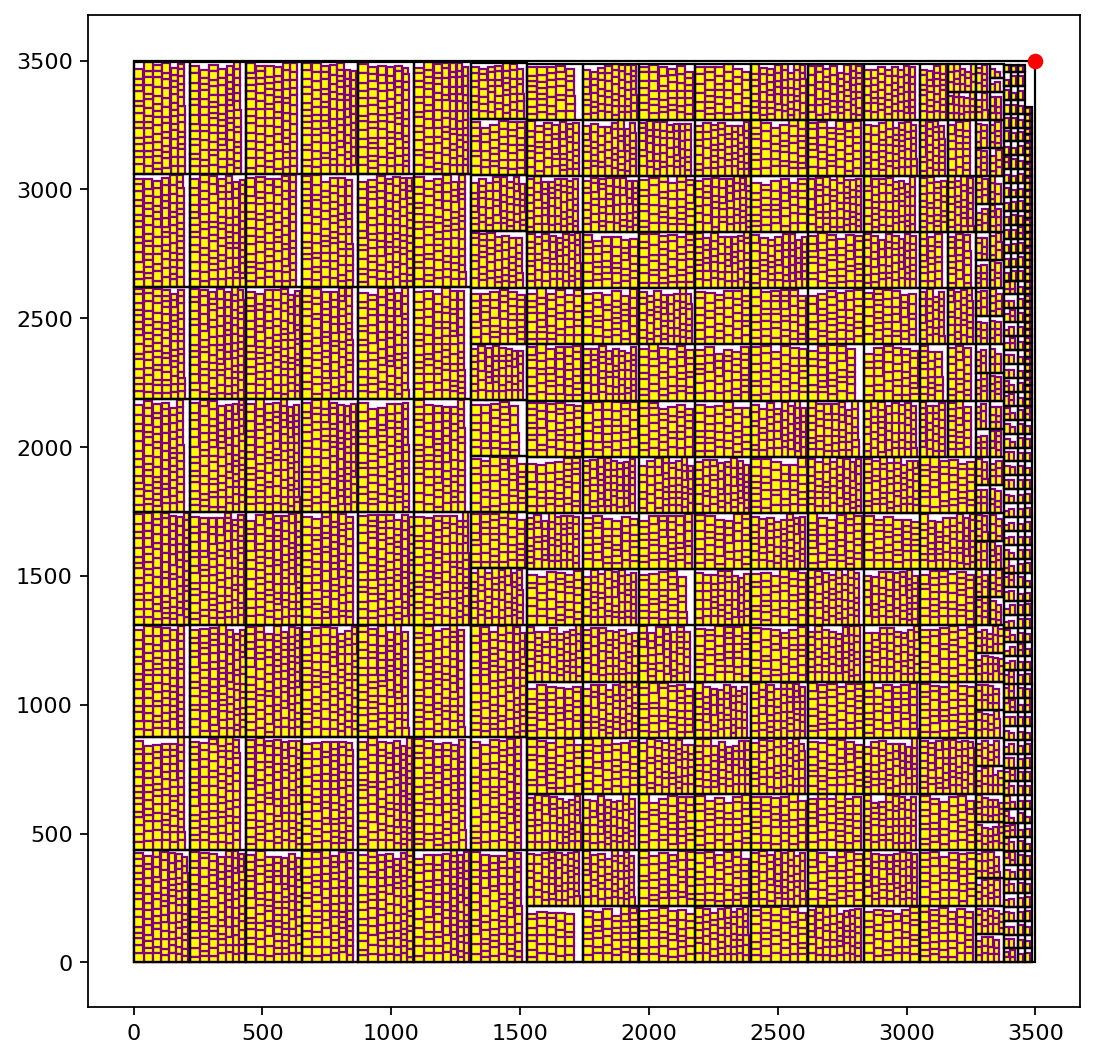

In [ ]:
from matplotlib.patches import Rectangle
def rec(x,y,l,w,color1, color2):
    rec= Rectangle((x,y),l,w,linewidth=1,edgecolor=color1,facecolor=color2)
    plt.gca().add_patch(rec)
from matplotlib.pyplot import figure
figure(figsize=(8, 16), dpi=160)
plt.gca().set_aspect('equal')

plt.plot(bin[0], bin[1], "ro")
rec(x=0,y=0,l=bin[0],w=bin[1],color1 = "black", color2='none')
idx_cluster = 3
bin_pack = draw_bin(idx_cluster)
item_pack = draw_item(idx_cluster)
item_pack = item_pack[item_pack[:,4] != -1]
for i in range(len(item_pack)):
    rec(x=item_pack[i,2], y=item_pack[i,3],l=item_pack[i,0],w=item_pack[i,1], color1 = "purple", color2="yellow")
for j in range(len(bin_pack)):
    rec(x=bin_pack[j,2],y=bin_pack[j,3],l=bin_pack[j,0],w=bin_pack[j,1],color1 = "black", color2='none')